In [18]:
import sys
# The first step is to import all the library that we will be using in our script
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

#from scipy import signal
import cv2
import sys

In [19]:
def dualpol2rgb(like,cross,sartype='amp',ndv=0):
    CF=np.power(10.,-8.3)
    if np.isnan(ndv):
        mask=np.isnana(cross)
    else:
        mask=np.equal(cross,ndv)
        
    l = np.ma.array(like,mask=mask,dtype=np.float32)
    c = np.ma.array(cross,mask=mask,dtype=np.float32)
    if sartype=='amp':
        l=np.ma.power(l,2.)*CF
        c=np.ma.power(l,2.)*CF
    elif sartype=='dB':
        l=np.ma.power(10.,l/10.)
        c=np.ma.power(10.,c/10.)
    elif sartype=='pwr':
        pass
    else:
        print('invalid type ',sartype)
        raise RuntimeError
    
    if sartype=='amp':
        ratio=np.ma.sqrt(l/c)/10
        ratio[np.isinf(ratio.data)]=0.00001
    elif sartype=='dB':
        ratio=10.*np.ma.log10(l/c)
    else:
        ratio=l/c
        
    ratio=ratio.filled(ndv)
    rgb=np.dstack((like,cross,ratio.data))
    bandnames=('Like','Cross','Ratio')
    return rgb

def any2amp(raster,sartype='amp',ndv=0):
    CF=np.power(10.,-8.3)
    mask=raster==ndv
    if sartype=='pwr':
        raster=np.sqrt(raster/CF)
    elif sartype=='dB':
        raster=np.ma.power(10.,(raster+83)/20.)
    elif sartype=='amp':
        pass
    else:
        print('invalid type ',sartype)
        raise RuntimeError
        
    raster[raster<1]=1
    raster[raster>65535]=65535
    raster[mask]=0
    raster=np.ndarray.astype(raster,dtype=np.uint16)
    return raster

In [20]:
def plot_aop_rgb(rgbArray,ls_pct=1,plot_title='VV, VH, VV/VH'):

    from skimage import exposure

    #pLow, pHigh = np.percentile(rgbArray, (ls_pct,100-ls_pct))
    pLow=np.percentile(rgbArray,ls_pct)
    pHigh=np.percentile(rgbArray,100-ls_pct)

    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [21]:
# here is where you save your images
datafolder=r'C:\Users\vaak\Desktop\UoS\weedwatch project\S1_Vembanad\STK'


#%% Loading the images
print('Reading pre-stored stack of patches...')    
#[C11, C22_full, C12] = np.load(path_save + 'filename.npy')
images_orig=np.load(datafolder + '\TrainingData_Vembanadlake_64.npy')
bandnbr=0
rgb=images_orig[bandnbr,:,:,:]
print(rgb.shape)
rgb=dualpol2rgb(rgb[:,:,0],rgb[:,:,1],sartype='dB',ndv=0)



rgb_stretched=np.ndarray.astype(rgb,'float32')

Reading pre-stored stack of patches...
(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


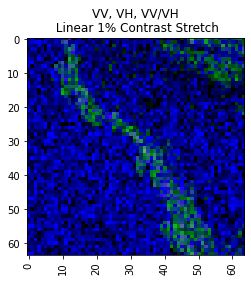

In [22]:
plot_aop_rgb(rgb_stretched,ls_pct=1,plot_title = 'VV, VH, VV/VH')

In [6]:
from IPython.html.widgets import *
from skimage import exposure

rgbArray = rgb_stretched

def linearStretch(percent):
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale)
    plt.title('RGB \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

interact(linearStretch,percent=(0,20,1))

C:\Users\vaak\Anaconda3\envs\snappy\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=10, description='percent', max=20), Output()), _dom_classes=('widget-int…

<function __main__.linearStretch(percent)>

Text(0, 0.5, 'Line')

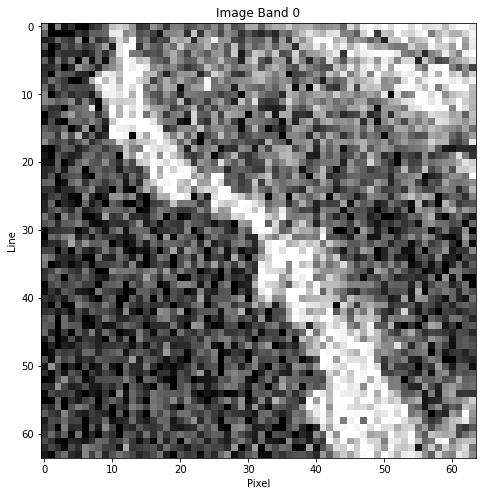

In [9]:

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
# If vmin or vmax are None we use percentiles as limits:
vmin=np.percentile(rgb[:,:,1].flatten(),5)
vmax=np.percentile(rgb[:,:,1].flatten(),95)

ax1.imshow(rgb[:,:,1],cmap='gray',vmin=vmin,vmax=vmax)
ax1.set_title('Image Band {}'.format(bandnbr))
ax1.xaxis.set_label_text('Pixel')
ax1.yaxis.set_label_text('Line')

In [50]:
#intPt = np.zeros([100,2])


bandnbr=0
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter0 = path.contains_points(points)
mask_clutter0 = mask_clutter.reshape((ny,nx))



C:\Users\vaak\Anaconda3\envs\snappy\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


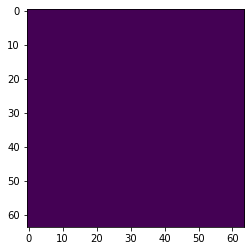

In [51]:
plt.imshow(mask_clutter0)

In [55]:
#intPt = np.zeros([100,2])


bandnbr=1
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter1 = path.contains_points(points)
mask_clutter1 = mask_clutter1.reshape((ny,nx))



In [57]:
#intPt = np.zeros([100,2])


bandnbr=2
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter2 = path.contains_points(points)
mask_clutter2 = mask_clutter2.reshape((ny,nx))



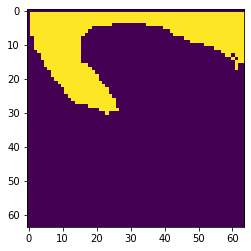

In [58]:
plt.imshow(mask_clutter2)

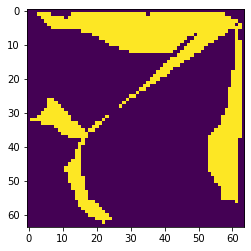

In [61]:
#intPt = np.zeros([100,2])


bandnbr=3
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter3 = path.contains_points(points)
mask_clutter3 = mask_clutter3.reshape((ny,nx))
plt.imshow(mask_clutter3)


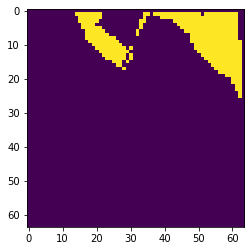

In [62]:
#intPt = np.zeros([100,2])


bandnbr=4
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter4 = path.contains_points(points)
mask_clutter4 = mask_clutter4.reshape((ny,nx))
plt.imshow(mask_clutter4)


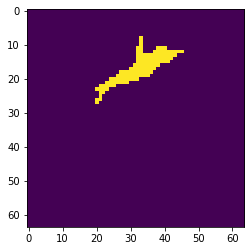

In [64]:
#intPt = np.zeros([100,2])


bandnbr=5
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter5 = path.contains_points(points)
mask_clutter5 = mask_clutter5.reshape((ny,nx))
plt.imshow(mask_clutter5)


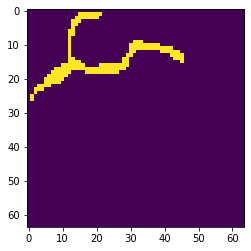

In [65]:
#intPt = np.zeros([100,2])


bandnbr=6
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter6 = path.contains_points(points)
mask_clutter6 = mask_clutter6.reshape((ny,nx))
plt.imshow(mask_clutter6)


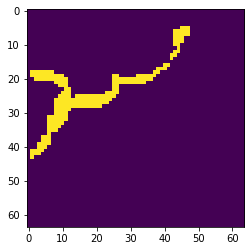

In [66]:
#intPt = np.zeros([100,2])


bandnbr=7
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter7 = path.contains_points(points)
mask_clutter7 = mask_clutter7.reshape((ny,nx))
plt.imshow(mask_clutter7)


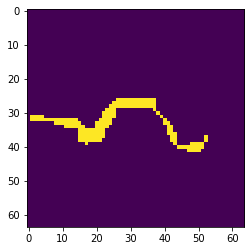

In [67]:
#intPt = np.zeros([100,2])


bandnbr=8
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter8 = path.contains_points(points)
mask_clutter8 = mask_clutter8.reshape((ny,nx))
plt.imshow(mask_clutter8)


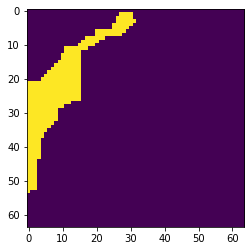

In [68]:
#intPt = np.zeros([100,2])


bandnbr=9
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter9 = path.contains_points(points)
mask_clutter9 = mask_clutter9.reshape((ny,nx))
plt.imshow(mask_clutter9)


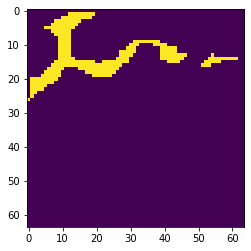

In [69]:
#intPt = np.zeros([100,2])


bandnbr=10
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter10 = path.contains_points(points)
mask_clutter10 = mask_clutter10.reshape((ny,nx))
plt.imshow(mask_clutter10)


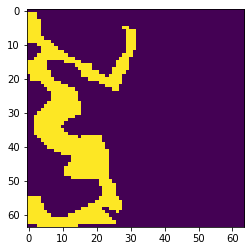

In [70]:
#intPt = np.zeros([100,2])


bandnbr=11
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter11 = path.contains_points(points)
mask_clutter11 = mask_clutter11.reshape((ny,nx))
plt.imshow(mask_clutter11)


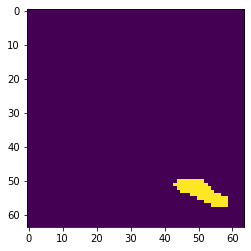

In [71]:
#intPt = np.zeros([100,2])


bandnbr=12
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter12 = path.contains_points(points)
mask_clutter12 = mask_clutter12.reshape((ny,nx))
plt.imshow(mask_clutter12)


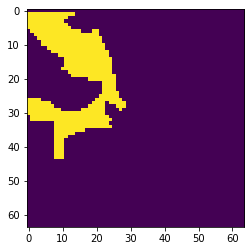

In [72]:
#intPt = np.zeros([100,2])


bandnbr=12
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter12_2 = path.contains_points(points)
mask_clutter12_2 = mask_clutter12_2.reshape((ny,nx))
plt.imshow(mask_clutter12_2)


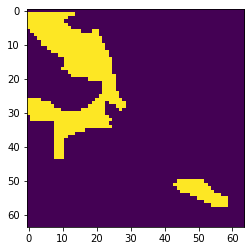

In [76]:
mask_clutte12=mask_clutter12_2| mask_clutter12
plt.imshow(mask_clutte12)


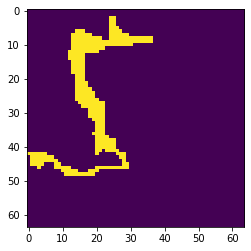

In [77]:
#intPt = np.zeros([100,2])


bandnbr=13
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter13 = path.contains_points(points)
mask_clutter13 = mask_clutter13.reshape((ny,nx))
plt.imshow(mask_clutter13)


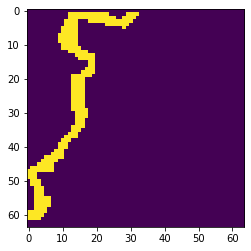

In [78]:
#intPt = np.zeros([100,2])


bandnbr=14
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter14 = path.contains_points(points)
mask_clutter14 = mask_clutter14.reshape((ny,nx))
plt.imshow(mask_clutter14)


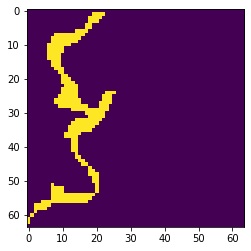

In [79]:
#intPt = np.zeros([100,2])


bandnbr=15
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter15 = path.contains_points(points)
mask_clutter15 = mask_clutter15.reshape((ny,nx))
plt.imshow(mask_clutter15)


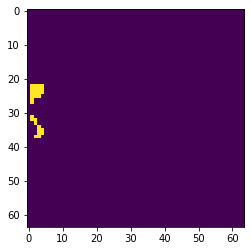

In [80]:
#intPt = np.zeros([100,2])


bandnbr=15
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter15_1 = path.contains_points(points)
mask_clutter15_1 = mask_clutter15_1.reshape((ny,nx))
plt.imshow(mask_clutter15_1)


In [81]:
mask_clutter15=mask_clutter15_1|mask_clutter15

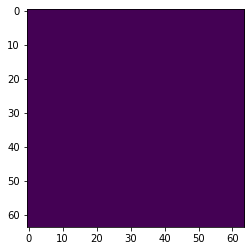

In [83]:
#intPt = np.zeros([100,2])


bandnbr=16
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter0_c = path.contains_points(points)
mask_clutter0_c = mask_clutter0_c.reshape((ny,nx))
plt.imshow(mask_clutter0_c)


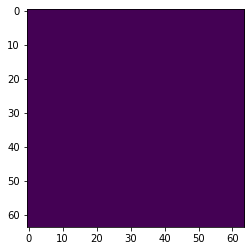

In [84]:
#intPt = np.zeros([100,2])


bandnbr=17
C22=images_orig[bandnbr,:,:,1]

intPt = []
#coordinates = np.ones([1,2])
coordinates = []
#np.zeros([100,2], dtype = int)

def nothing(x):
    pass


# decide here how big you want your image
size_image = 10000


dim1 = np.shape(C22)[0]
dim2 = np.shape(C22)[1]
block1 = int(np.ceil(dim1/size_image))
block2 = int(np.ceil(dim2/size_image))
for j in range(0, block1):
    for jj in range(0, block2):
        
        image = []
        
#        if      q           
        image = np.abs(C22[j*size_image:j*size_image+size_image, jj*size_image:jj*size_image+size_image])
        clone = image.copy()
        k = 2.5            # Initial setting for contrast
        
        
        
        
        def click_and_store(event, x, y, flags, param):
            	# grab references to the global variables
            	global intPt
                
            	if event == cv2.EVENT_LBUTTONDOWN:
                     intPt.append((x, y))
    
        # Building window and trackbar to set the constrast
        cv2.namedWindow("r: redo, q: save&finish", cv2.WINDOW_KEEPRATIO)
        cv2.createTrackbar('Contrast','r: redo, q: save&finish', 2, 10, nothing)
        cv2.setMouseCallback('r: redo, q: save&finish', click_and_store)
        
         
        # keep looping until the 'q' key is pressed
        while True:
            # display the image and wait for a keypress
            cv2.imshow('r: redo, q: save&finish', clone)
#            cv2.putText(clone,'Block 1', (10, 10), 2, 2, (255, 0, 0)) 
            
        
            key = cv2.waitKey(1) & 0xFF
            
            clone = image/(np.mean(image)*k)*255
            clone = cv2.convertScaleAbs(clone)   

            
            # Inefficient but works
            for i in range(0,int(np.size(intPt)/2-1)):
                Pt = intPt[i]
                cv2.circle(clone, tuple(Pt), 1, (255, 0, 0), 1)
            
            
            # get current positions of trackbars
            k = cv2.getTrackbarPos('Contrast','r: redo, q: save&finish')
            
             
        	 # if the 'r' key is pressed, reset the cropping region
            if key == ord("r"):
                clone = image.copy()
                intPt = []
        
            elif key == ord("q"):
                intPt.append((0,0))     # if not adding this it loses the last point

                if intPt != []:
                    # before saving we need to add the absolute position in the image
                    points = np.array(intPt)
                    points = points[~np.all(points == 0, axis=1)]   # removing dummy point
#                    points = np.fliplr(points)
                    points[:,0] = points[:,0] + j*size_image
                    points[:,1] = points[:,1] + jj*size_image
                    coordinates.append(points)
                intPt = []
        #        intPt.append((0,0))
                break
            
#            
                
        
 # close all open windows
cv2.destroyAllWindows()



#%%
# assigning this to an array now
coord = np.zeros([1000,2])
dim = np.shape(coordinates)[0]

for i in range(0, dim):
    dim_small = np.shape(coordinates[i])[0]
    for ii in range(0, dim_small):
        coord[k] = coordinates[i][ii,:]
        k = k + 1

coord_clutter = coord[~np.all(coord == 0, axis=1)]
coord_clutter = coord_clutter.astype(int)
#coord_target = np.fliplr(coord_target)



#%% CREATING POLYGON MASK 
nx, ny = dim2, dim1
poly_verts = coord_clutter

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

path = Path(poly_verts)
mask_clutter1_c = path.contains_points(points)
mask_clutter1_c = mask_clutter1_c.reshape((ny,nx))
plt.imshow(mask_clutter1_c)


In [87]:
mask_clutter2_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter3_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter4_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter5_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter6_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter7_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter8_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter9_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter10_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter11_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter12_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter13_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter14_c = mask_clutter0_c.reshape((ny,nx))
mask_clutter15_c = mask_clutter0_c.reshape((ny,nx))


In [95]:
mask_clutter=np.stack((mask_clutter0,mask_clutter1,mask_clutter2,mask_clutter3,mask_clutter4,mask_clutter5,mask_clutter6,
                  mask_clutter7,mask_clutter8,mask_clutter9,mask_clutter10,mask_clutter11,mask_clutter12,
                   mask_clutter13,mask_clutter14,mask_clutter15,
                   mask_clutter0_c,mask_clutter1_c,mask_clutter2_c,
                   mask_clutter3_c,mask_clutter4_c,mask_clutter5_c,
                   mask_clutter6_c, mask_clutter7_c, mask_clutter8_c,
                   mask_clutter9_c,mask_clutter10_c,mask_clutter11_c,
                   mask_clutter12_c,mask_clutter13_c,mask_clutter14_c,
                   mask_clutter15_c))

In [97]:
np.save(datafolder + '\GTData_Vembanadlake_64', mask_clutter)

In [96]:
mask_clutter.shape

(32, 64, 64)